Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from statannotations.Annotator import Annotator

Load data and group single cell data based on Well & Replicate

In [35]:
# Load the CSV files of replicate experimental data
data_exp03 = pd.read_csv('Data/Data_Exp03_IF_HC.csv')
data_exp05 = pd.read_csv('Data/Data_Exp05_IF_HC.csv')
data_exp06 = pd.read_csv('Data/Data_Exp06_IF_HC.csv')

# Merge the dataframes into a single dataframe
main_df = pd.concat([data_exp03, data_exp05, data_exp06]).reset_index(drop=True)

# Create new columns
main_df['NucleiCytoplasm_Intensity_MeanIntensity_NFKB'] = main_df['Nuclei_Intensity_MeanIntensity_NFKB']/(main_df['Nuclei_Intensity_MeanIntensity_NFKB']+main_df['Cytoplasm_Intensity_MeanIntensity_NFKB'])
main_df['NucleiCytoplasm_Intensity_SumIntensity_NFKB'] = main_df['Nuclei_Intensity_SumIntensity_NFKB']/(main_df['Nuclei_Intensity_SumIntensity_NFKB']+main_df['Cytoplasm_Intensity_SumIntensity_NFKB'])

# Drop unwanted columns
main_df = main_df.drop(columns=[' X', ' Y'])

#Keep single cell data
single_cell_df = main_df.copy()

# Group the data based on 'Replicate' and 'Well' and calculate the mean
main_df = main_df.groupby(['Replicate', 'Category', 'Well']).mean().reset_index()

Plot settings

In [39]:
# What to plot?
data = main_df.copy()
x = 'Category'
y = 'NucleiCytoplasm_Intensity_MeanIntensity_NFKB' # number_ASC, Cytoplasm_AreaShape_Area_CD45, NucleiCytoplasm_Intensity_MeanIntensity_NFKB
ytitle = y
order = ['Untreated', 'LPS', 'Nigericin', 'LPS/Nigericin']
hue = 'Category'

# Set colors
# Define a dictionary that maps categories to colors
color_dict = {'Untreated': 'gray', 'LPS': 'orange', 'Nigericin': 'red', 'LPS/Nigericin': 'purple'}

# Set the style and font
plt.rcParams["font.family"] = "Arial"
sns.set_context('talk')

Create super plot showing all data points and replicate medians

c:\Users\JohannesWilbertz\anaconda3\envs\tools\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\JohannesWilbertz\anaconda3\envs\tools\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Untreated vs. LPS: t-test independent samples, P_val:6.921e-02 t=-2.467e+00
Untreated vs. Nigericin: t-test independent samples, P_val:2.267e-01 t=1.427e+00
Untreated vs. LPS/Nigericin: t-test independent samples, P_val:2.071e-01 t=1.503e+00


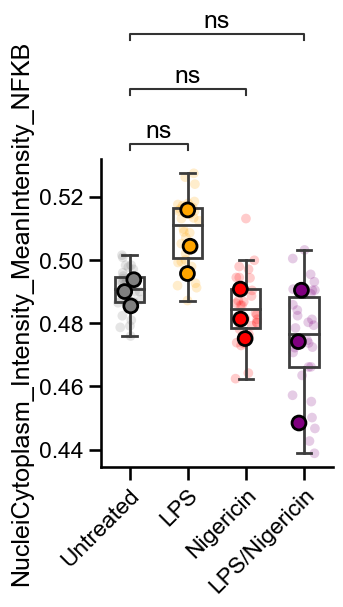

In [ ]:
# Create the plot
plt.figure(figsize=(3, 4))

# Boxplot
ax = sns.boxplot(x=x, y=y, data=data, showfliers=False, hue=hue, order=order, zorder=1, width=0.5, linewidth=2, dodge=False)  
# Transparancy of boxplot filling color
for patch in ax.patches: #patches
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))

ax = sns.stripplot(x=x, y=y, data=data, size=7, alpha=0.2, zorder=0, hue=hue, order=order, jitter=0.2, palette=color_dict, dodge=False)

# Add replicate averages on top of plot
ReplicateAverages = data.groupby([x, 'Replicate'], as_index=False).agg({y: "median"})
ReplicateAverages = ReplicateAverages.sort_values([x, 'Replicate']) # Sorting is necessary to plot averages accurately on dataclouds

ax = sns.stripplot(x=x, y=y, size=10, edgecolor="k", linewidth=2, palette=color_dict, data=ReplicateAverages, order=order, jitter=0.1, hue=hue, dodge=False)

# Figure aesthetics
ax.set(xlabel=None)
ax.set(ylabel=y)
ax.set_ylim(0, None)
sns.despine()
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")

# Add statistical annotation on top of figure
pairs=[
    ("Untreated", "LPS"),
    ("Untreated", "Nigericin"),
    ("Untreated", "LPS/Nigericin")
    ]

annot = Annotator(ax, pairs, data=ReplicateAverages, x=x, y=y, order=order)
annot.configure(test='t-test_ind', verbose=2, loc='outside')
annot.apply_test()
annot.annotate()

# Saving plot
plt.savefig(y + '.pdf', bbox_inches='tight')

plt.show()